In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from eam_core import ureg, Q_
import pandas as pd
import numpy as np
from datetime import datetime

[root                ][INFO   ]  Configured logging from /Users/jedpreist/CodingStuff/DIMPACT/eam-core-provenance/src/eam_core/logconf.yml (log_configuration.py:30)


# Example - Cellular Energy Intensity

## General Sim Params

In [2]:
start_date = '2010-01-01'
end_date = '2030-12-01'
date_range = pd.date_range(start_date, end_date, freq='MS')

from dateutil import relativedelta
r = relativedelta.relativedelta( datetime.strptime(end_date, '%Y-%m-%d'), datetime.strptime(start_date,'%Y-%m-%d'))
months = r.years * 12 + r.months + 1

samples = 100

In [3]:
date_range[0].to_pydatetime()

datetime.datetime(2010, 1, 1, 0, 0)

## Distribution param values

In [4]:
mu_2010 = 1.17e-3 # 10e-4 J/b
ref_date = '2010-01-01'
alpha=-.22

## Config Dict

In [5]:
mu_conf = {'type':'exp', 'initial':mu_2010, 'ref_date': ref_date, 'growth_factor':alpha}

# 1. Generate $\mu$

In [6]:
import table_data_reader as helper
from datetime import datetime

In [7]:
mu_bar = np.full(len(date_range), mu_conf['initial'])

# 2. Apply Growth to Mean Values $\alpha_{mu}$

In [8]:
alpha_mu = helper.growth_coefficients(
    datetime.strptime(start_date,'%Y-%m-%d'), 
    datetime.strptime(end_date, '%Y-%m-%d'), 
    datetime.strptime(mu_conf['ref_date'],'%Y-%m-%d'), 
    mu_conf['growth_factor'], 1)

In [9]:
mu = mu_bar * alpha_mu.ravel()
mu = mu.reshape(len(date_range),1)

# 3. Generate $\sigma$

## Config Dictionary

In [10]:
sigma_conf = {'type':'exp', 
              'variance': mu_conf['initial']/10, 
#               'mode': mu_2010, 
#               'right':mu_2010 + mu_2010/10,
              'ref_date': ref_date, 
              'growth_factor':.1}

## Prepare array with growth values $\sigma$

In [11]:
sample_mean = False
if sample_mean:
    sigma = np.zeros((len(date_range),samples))
else:
    sigma = np.random.triangular(-1*sigma_conf['variance'], 0, sigma_conf['variance'], (len(date_range),samples))

## 4. Prepare growth array for $\alpha_{sigma}$ 

In [12]:
alpha_sigma = helper.growth_coefficients(
    datetime.strptime(start_date,'%Y-%m-%d'), 
    datetime.strptime(end_date, '%Y-%m-%d'), 
    datetime.strptime(mu_conf['ref_date'],'%Y-%m-%d'), 
    sigma_conf['growth_factor'], samples)

### 5. Prepare DataFrame

In [13]:

iterables = [date_range, range(samples)]
index_names = ['time', 'samples']
_multi_index = pd.MultiIndex.from_product(iterables, names=index_names)

df = pd.DataFrame(index=_multi_index, dtype=float)

## Apply growth to $\sigma$ and add $\sigma$ to $\mu$

In [14]:

df['sigma'] = ((sigma * alpha_sigma) + mu.reshape(months,1)).ravel()

# 6. Plot

In [15]:
_mean = df['sigma'].mean(level='time')
# _std = df['sigma'].std(level='time')

lci=df['sigma'].groupby(level=['time']).quantile(.05)
uci=df['sigma'].groupby(level=['time']).quantile(.95)

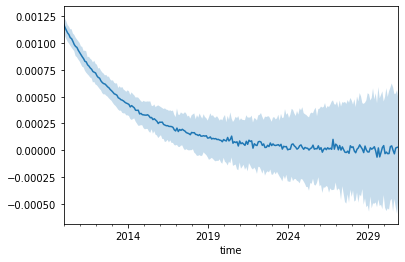

In [16]:
ax = _mean.plot()
ax.fill_between(df.index.unique(level='time'), lci, uci, alpha=.25)

## test if df has sub-zero values

In [17]:
df['sigma'].where(df['sigma']<0).dropna().empty

[numexpr.utils       ][INFO   ]  NumExpr defaulting to 8 threads. (utils.py:157)


False

## get index of first sub zero value

In [18]:
df['sigma'].where(df['sigma']<0).dropna().index[0][0]

Timestamp('2017-01-01 00:00:00', freq='MS')

# Addiontional Plots

In [19]:
df['error'] = (sigma * alpha_sigma).ravel()

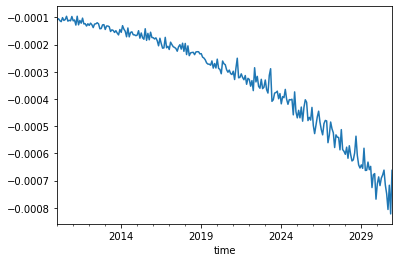

In [20]:
ax = df['error'].min(level='time').plot()

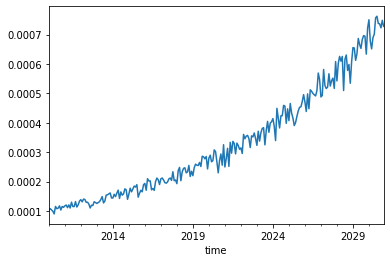

In [21]:
ax = df['error'].max(level='time').plot()

In [22]:
df['avg'] = (mu.ravel() * np.ones((samples, months))).T.ravel()

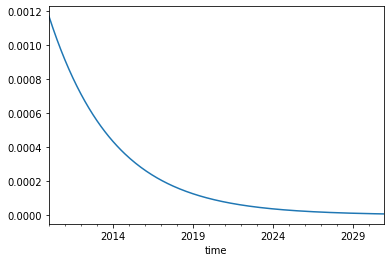

In [23]:
df['avg'].mean(level='time').plot()

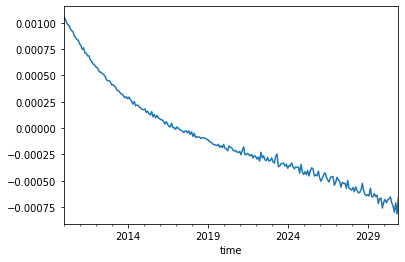

In [24]:
ax = df['sigma'].min(level='time').plot()

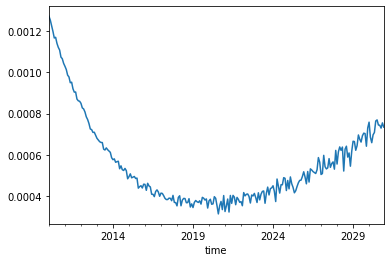

In [25]:
ax = df['sigma'].max(level='time').plot()

## some sample histograms of monthly distributions

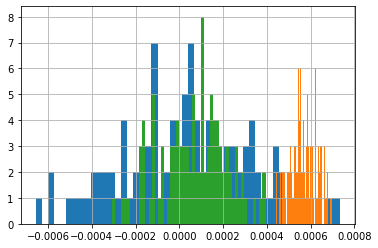

In [26]:
df['sigma']['2030-12-01'].hist(bins=50)
df['sigma']['2012-12-01'].hist(bins=50)
df['sigma']['2022-12-01'].hist(bins=50)

In [27]:
plt.gcf().clear()

<Figure size 432x288 with 0 Axes>